In [ ]:
# Code for the Book: International Stock Picking A.I. INVESTOR: A Guide to Build.
# Website: ai-investor.net
# Code needs am "All-In-One" subscription from the (presumably) nice people at https://eodhistoricaldata.com/. 
# Check the book text to see if they have changed their service since mid-2021.

# Damon Lee 2021

# Feel free to fork this code for others to see what can be done with it.

In [2]:
myToken = 'ABC123.XXXXXX.84098767' # Own token from EODHistoricalData

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import requests

from myFunctions import *

# Set the plotting DPI settings to be a bit higher.
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

# Get X and y

In [4]:
stockData = pd.read_csv('stockData_2021.csv')
stockData['date']=pd.to_datetime(stockData['date'])
priceData = pd.read_csv('priceData_2021.csv', index_col=0)

print(priceData.shape) # Check the DataFrame sizes
print(stockData.shape)
print(priceData.index[-1])
print(stockData.index[-1])

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,10,12,14,22,23,42) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(536962, 15)
(536960, 152)
536959
536959


# Investigating the Figures 
# Feel free to skip to "All Steps Combined into One Function" Section
# (combines all of this together)

In [5]:
stockData.count().to_csv('counts.csv')

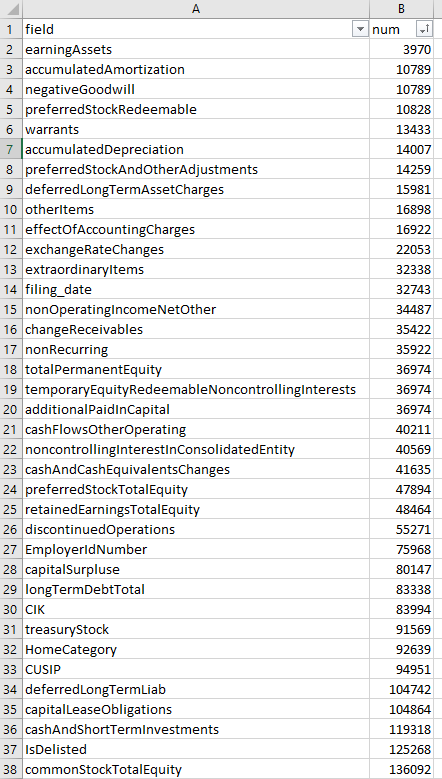

In [6]:
priceData = priceData[priceData['startAdjusted_close']>0] # buggy data
priceData = priceData[priceData['endAdjusted_close']>0]   # buggy data
priceData=priceData.dropna()
stockData = stockData.loc[priceData.index]
print(priceData.shape)
print(stockData.shape)

stockData['Market Cap'] = (stockData['SharesOutstanding'] * priceData['startClose']).clip(0,2e13)
stockData=stockData[stockData['Market Cap']>0] # Imperfect data
#stockData=stockData[stockData['netIncome']>0] # Want only companies that earn 
stockData=stockData[stockData['totalRevenue']>0] # Only companies with revenue
stockData=stockData[stockData['Exchange']!='PINK'] # Don't want pink sheets
stockData=stockData[stockData['CountryName']!='Germany'] # Many dual listings 
stockData=stockData[stockData['Industry']!='Other Industrial Metals & Mining'] # Mining companies
stockData=stockData[stockData['Industry']!='Oil & Gas E&P'] # Oil and gas 
priceData = priceData.loc[stockData.index]
print(priceData.shape)
print(stockData.shape)

(384511, 15)
(384511, 152)
(264008, 15)
(264008, 153)


### Market Cap

<AxesSubplot:>

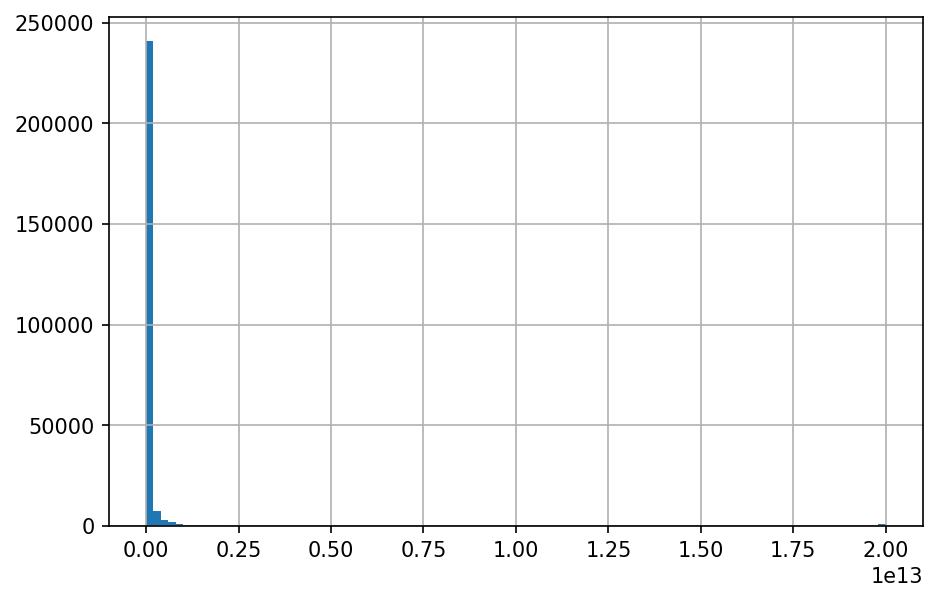

In [7]:
stockData['Market Cap'] = (stockData['SharesOutstanding'] \
                           * priceData['startClose']).clip(0,2e13)
stockData=stockData[stockData['Market Cap'] > 0] # Imperfect data
stockData['Market Cap'].hist(bins=100)

### Cash

In [8]:
stockData[stockData['cashAndShortTermInvestments'] < stockData['cash']].shape # Should have 0 companies

(3960, 153)

In [9]:
stockData['cashAndShortTermInvestments'] = \
np.where(stockData['cashAndShortTermInvestments'] < stockData['cash'], 
         stockData['cash'],
         stockData['cashAndShortTermInvestments'])

In [10]:
stockData[stockData['cashAndShortTermInvestments'] < stockData['cash']].shape # Fixed

(0, 153)

### Current Liabilities

In [11]:
stockData[stockData['totalCurrentLiabilities'] < stockData['otherCurrentLiab']].shape # Should have 0 companies

(1594, 153)

In [12]:
stockData['totalCurrentLiabilities'] = \
np.where(stockData['totalCurrentLiabilities'] < stockData['otherCurrentLiab'], 
         stockData['otherCurrentLiab'],
         stockData['totalCurrentLiabilities'])

In [13]:
stockData[stockData['totalCurrentLiabilities'] < stockData['otherCurrentLiab']].shape # Fixed

(0, 153)

### Current Assets

In [14]:
stockData[stockData['totalCurrentAssets']==0].shape # Should have 0 companies too

(67, 153)

In [15]:
stockData[stockData['totalCurrentAssets'] < stockData['otherCurrentAssets']].shape # Should have 0 companies too

(1607, 153)

In [16]:
stockData['totalCurrentAssets'] = \
np.where(stockData['totalCurrentAssets'] < stockData['otherCurrentAssets'],
         stockData['otherCurrentAssets'],
         stockData['totalCurrentAssets'])

In [17]:
stockData[stockData['totalCurrentAssets'] == 0].shape # Down from 66k issues to 17k.

(36, 153)

In [18]:
# Issue, still many companies with currentAssets of 0 (surely can't be the case!)
# We can see that the total assets figure almost never has 0's
stockData[stockData['totalAssets'] == 0].shape

(4, 153)

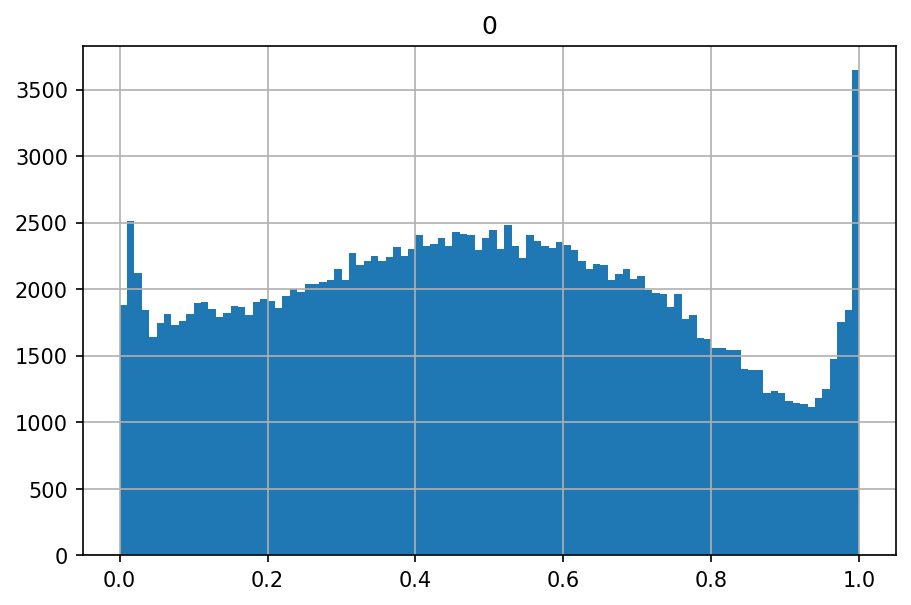

In [19]:
# Can check the distribution of the ratio between the current assets and total assets
# Pick the average and use that to fill in the 0s.
pd.DataFrame(stockData['totalCurrentAssets'] / stockData['totalAssets']).clip(0,1).hist(bins=100);

In [20]:
pd.DataFrame(stockData['totalCurrentAssets'] / stockData['totalAssets']).clip(0,1).mean()

0    0.482812
dtype: float64

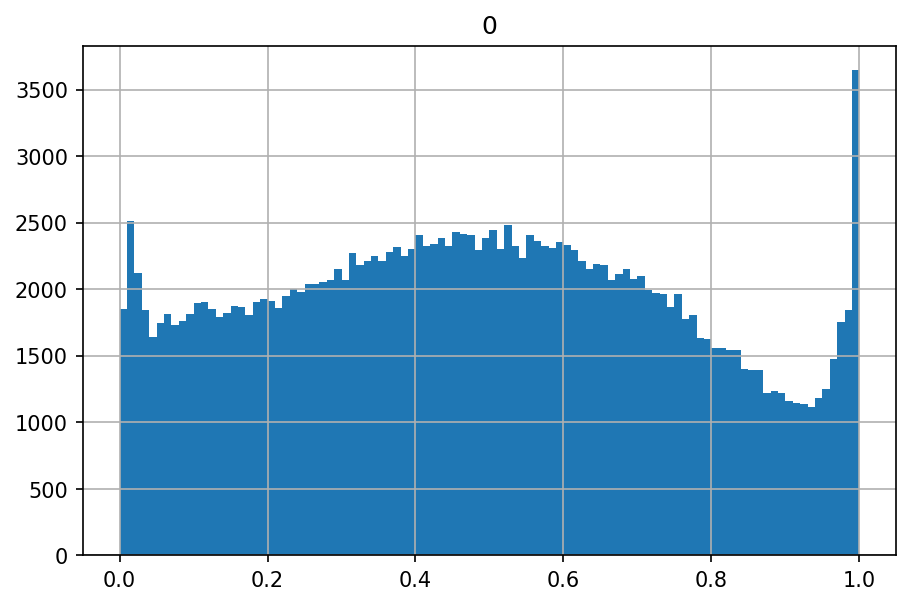

In [21]:
stockData['totalCurrentAssets'] = np.where(stockData['totalCurrentAssets']==0, 
                                           stockData['totalAssets']*0.36,
                                           stockData['totalCurrentAssets'])
pd.DataFrame(stockData['totalCurrentAssets'] / stockData['totalAssets']).clip(0,1).hist(bins=100);

### Non Current Assets

In [22]:
stockData[stockData['nonCurrentAssetsTotal']==0].shape # 170k rows bad!

(1086, 153)

In [23]:
stockData['nonCurrentAssetsTotal'] = \
np.where(stockData['nonCurrentAssetsTotal'] == 0, 
         stockData['totalAssets'] - stockData['totalCurrentAssets'],
         stockData['nonCurrentAssetsTotal'])

In [24]:
stockData[stockData['nonCurrentAssetsTotal']==0].shape # better

(195, 153)

### Total Stockholder Equity

In [25]:
stockData[stockData['totalStockholderEquity'] == 0].shape # bad!

(193, 153)

In [26]:
# Checking the equity figure.
stockData['totalStockholderEquityTest'] = \
stockData['totalAssets'] - stockData['totalLiab']

stockData['EquityDiff'] = \
abs((stockData['totalStockholderEquity'] - stockData['totalStockholderEquityTest'])/\
    stockData['totalStockholderEquity'])

stockData[stockData['EquityDiff']>0.2].shape # 40k at least 20% out.

(18846, 155)

In [27]:
stockData['totalStockholderEquity'] = stockData['totalAssets'] - stockData['totalLiab']

In [28]:
stockData[stockData['totalStockholderEquity'] == 0].shape # better

(234, 155)

### Gross Profit

In [29]:
stockData[stockData['grossProfit']==0]\
[['Code','totalRevenue','costOfRevenue','grossProfit']] # 60k rows! bad!

,Code,totalRevenue,costOfRevenue,grossProfit
8284,0094,17331000.0,736000.0,0.0
8289,0094,17595000.0,679000.0,0.0
8306,0094,18817000.0,792000.0,0.0
40614,1191,5467000.0,1647000.0,0.0
47228,1572,257199000.0,0.0,0.0
...,...,...,...,...
532063,YBOX,7720000.0,0.0,0.0
532064,YBOX,2807000.0,0.0,0.0
532356,YESIL,637000.0,0.0,0.0
532360,YESIL,170000.0,0.0,0.0


In [30]:
stockData['grossProfit'] = \
stockData['totalRevenue'] - stockData['costOfRevenue']

In [31]:
stockData[stockData['grossProfit']==0].shape # better!

(36, 155)

### Interest Expense

In [32]:
stockData['interestExpense'] < 0 # some false, some true

0          True
1          True
2          True
3          True
5          True
          ...  
536952    False
536954    False
536956    False
536957    False
536959    False
Name: interestExpense, Length: 264008, dtype: bool

In [33]:
stockData['interestExpense'] = stockData['interestExpense'].apply(np.abs)

### EBIT

In [34]:
stockData["EBIT"] = stockData["netIncome"] \
    - stockData["interestExpense"] \
    - stockData["incomeTaxExpense"]

### Enterprise Value

In [35]:
stockData['enterpriseValue'] = stockData['Market Cap']\
    +stockData['longTermDebtTotal']\
    +stockData['shortTermDebt']\
    -stockData['cashAndShortTermInvestments']

### Stock Returns

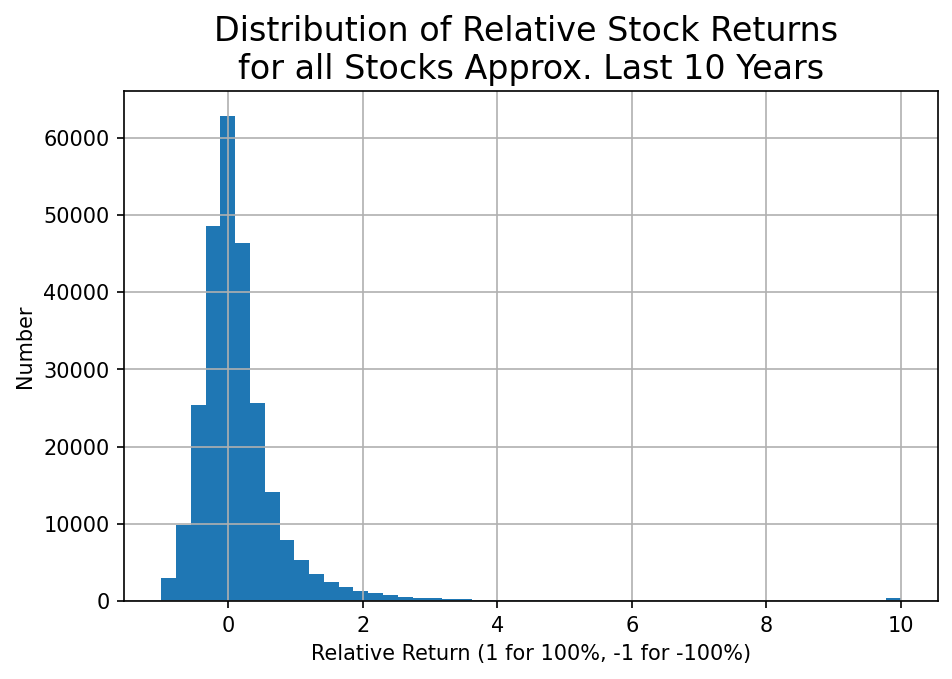

In [36]:
stockData['1YPerf'] = (priceData['endAdjusted_close'] - \
                       priceData['startAdjusted_close']) / \
                        priceData['startAdjusted_close']

stockData['1YPerf'] = stockData['1YPerf'].clip(-1,10)
stockData['1YPerf'].hist(bins=50)
plt.title('Distribution of Relative Stock Returns \nfor all Stocks Approx. Last 10 Years', fontsize=16);
plt.ylabel('Number');
plt.xlabel('Relative Return (1 for 100%, -1 for -100%)');

# Valuation Ratios (next section combines all of this together)

### Price/Book

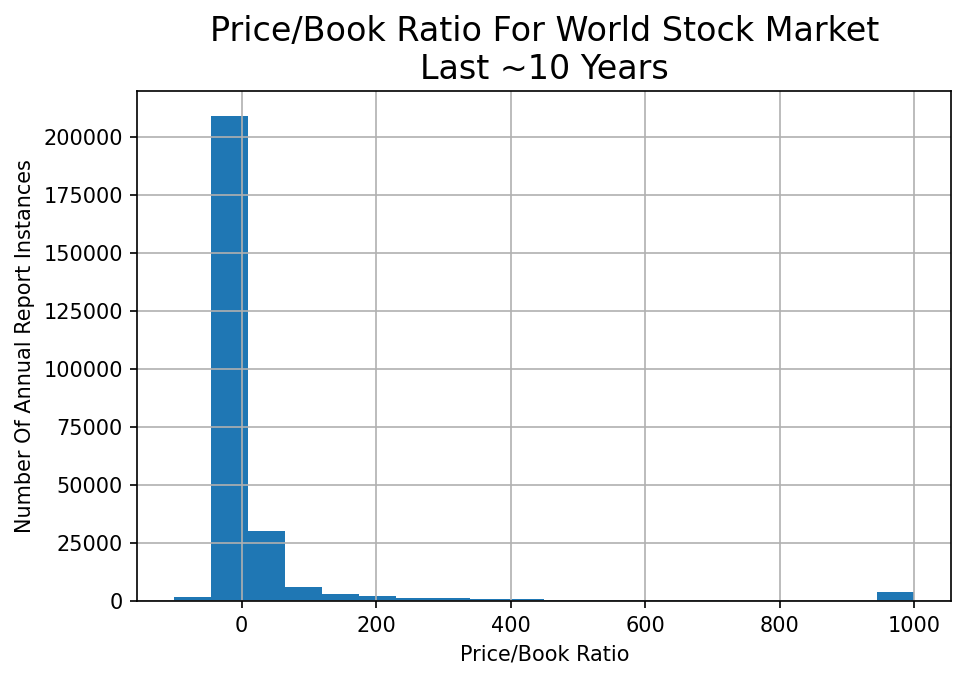

In [37]:
X = pd.DataFrame() # Our Features. X matrix.
X['P/B'] = (stockData['Market Cap'] / \
            stockData['totalStockholderEquity']).clip(-100,1000)
X['P/B'].hist(bins=20)
plt.title('Price/Book Ratio For World Stock Market\nLast ~10 Years', 
          fontsize=16);
plt.xlabel('Price/Book Ratio');
plt.ylabel('Number Of Annual Report Instances');

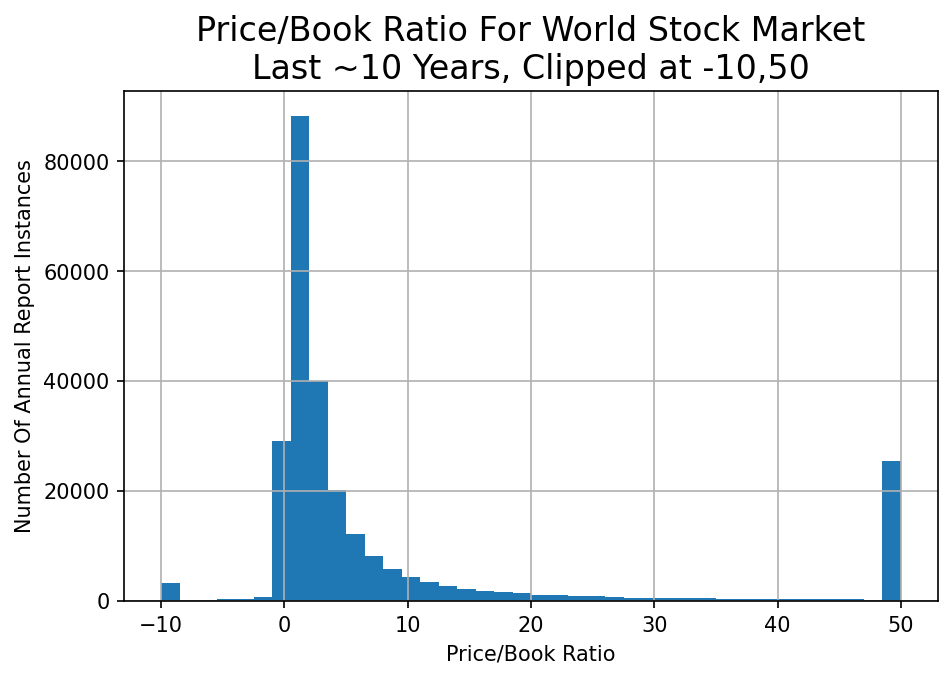

In [38]:
X['P/B'].clip(-10,50).hist(bins=40)
plt.title('Price/Book Ratio For World Stock Market'+\
          '\nLast ~10 Years, Clipped at -10,50', 
          fontsize=16);
plt.xlabel('Price/Book Ratio');
plt.ylabel('Number Of Annual Report Instances');

### Price/Earnings & Price/Sales

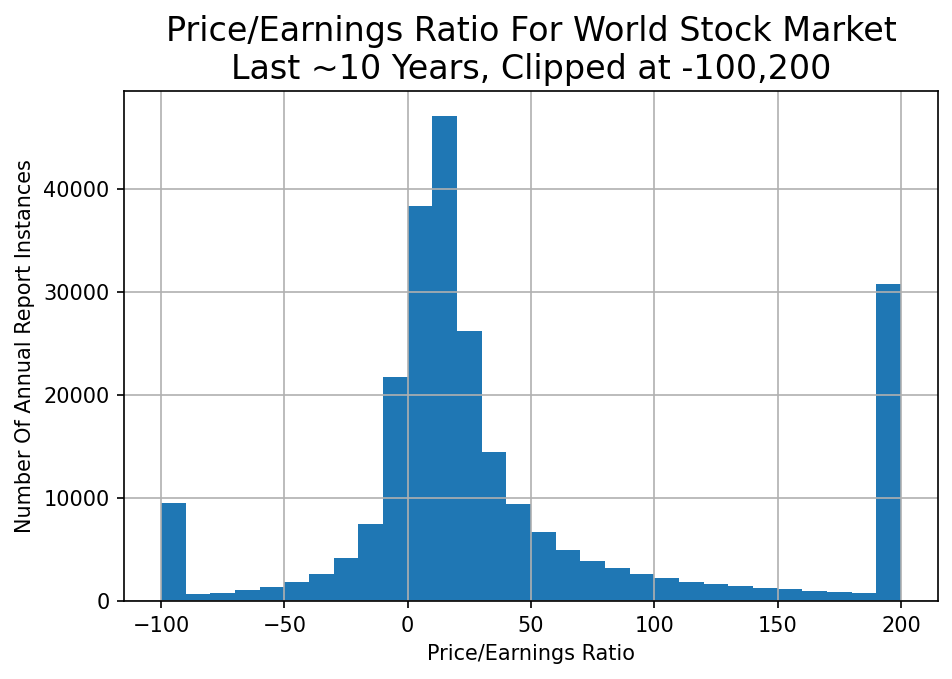

In [39]:
X['P/E'] = \
(stockData['Market Cap']/stockData['netIncome']).clip(-1000,5000)

#X['P/E'].hist(bins=20) # View distribution no clip
X['P/E'].clip(-100,200).hist(bins=30) # More informative interesting graph
plt.title('Price/Earnings Ratio For World Stock Market'+\
          '\nLast ~10 Years, Clipped at -100,200', 
          fontsize=16);
plt.xlabel('Price/Earnings Ratio');
plt.ylabel('Number Of Annual Report Instances');

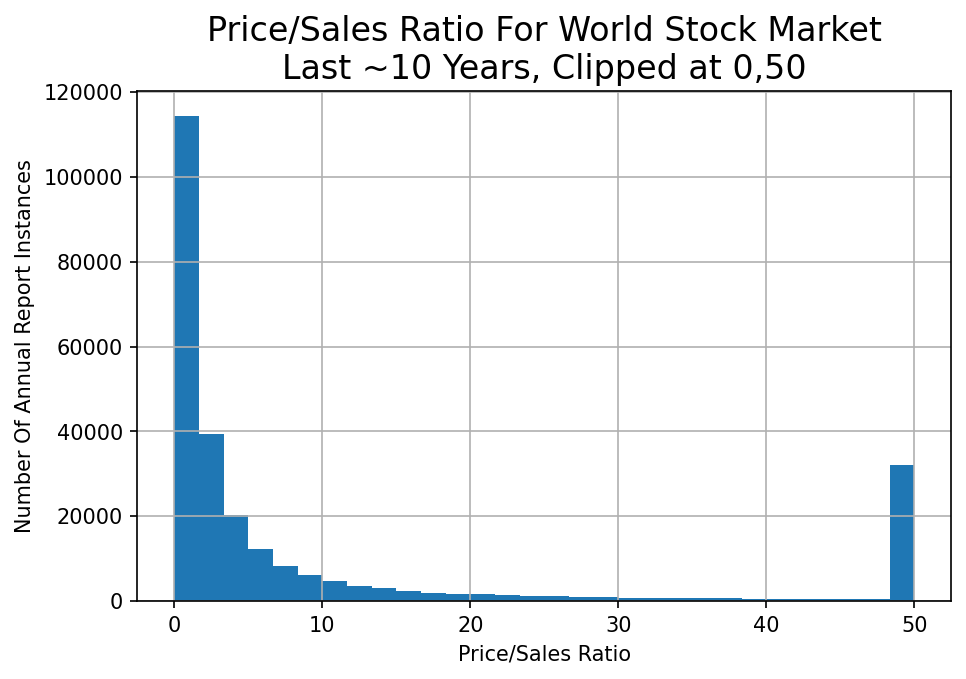

In [40]:
X['P/S'] = (stockData['Market Cap']/stockData['totalRevenue']).clip(0,5000)#0,100
#X['P/S'].hist(bins=20) # View distribution no clip
X['P/S'].clip(-100,50).hist(bins=30) # More informative interesting graph
plt.title('Price/Sales Ratio For World Stock Market'+\
          '\nLast ~10 Years, Clipped at 0,50', 
          fontsize=16);
plt.xlabel('Price/Sales Ratio');
plt.ylabel('Number Of Annual Report Instances');

### Return on Equity, 
### Return on Capital Employed, 
### Income to interest expense 
### and Gross Profit Margin

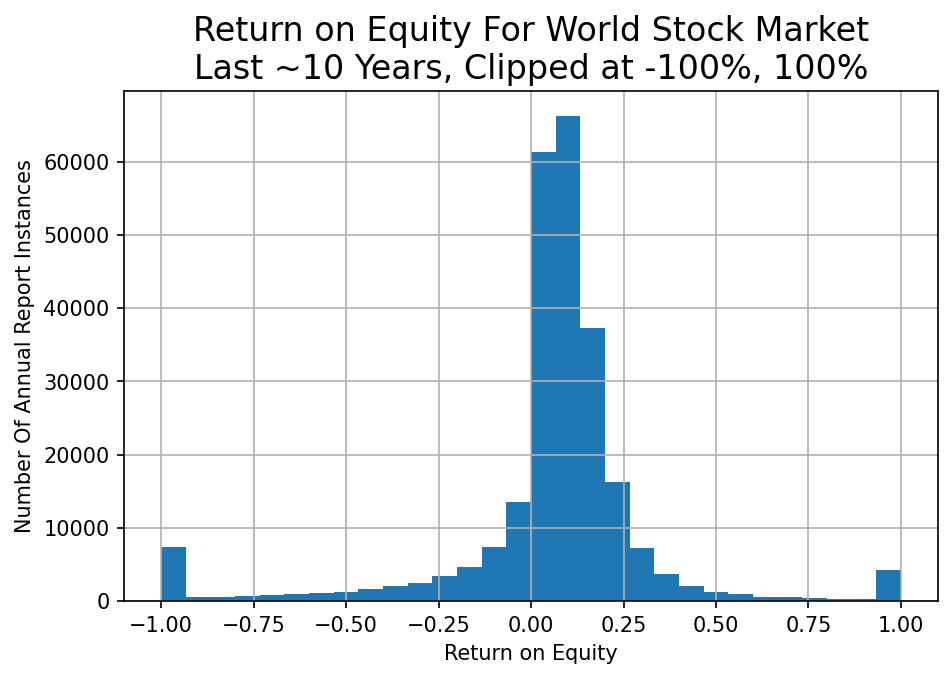

In [41]:
X['RoE'] = \
(stockData['netIncome']/stockData['totalStockholderEquity']).clip(-10,10)
#X['RoE'].hist(bins=30) # view graph
X['RoE'].clip(-1,1).hist(bins=30) # More informative graph
plt.title('Return on Equity For World Stock Market'+\
          '\nLast ~10 Years, Clipped at -100%, 100%', 
          fontsize=16);
plt.xlabel('Return on Equity');
plt.ylabel('Number Of Annual Report Instances');

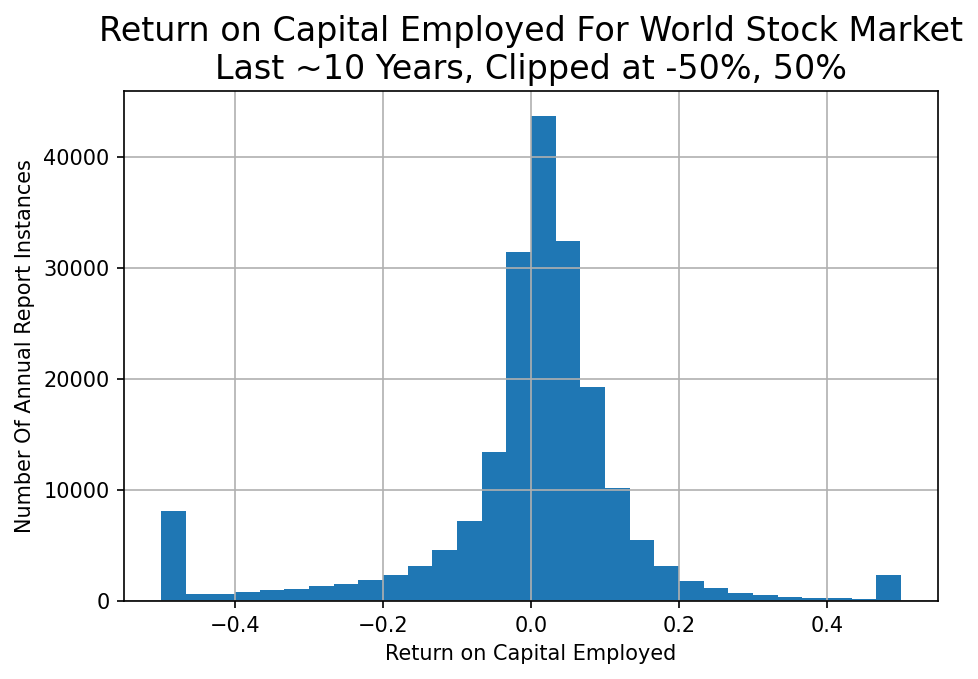

In [42]:
X['ROCE'] = \
(stockData['EBIT']/(stockData['totalAssets'] - \
                    stockData['totalCurrentLiabilities'])).clip(-2,2)

X['ROCE'].clip(-0.5,0.5).hist(bins=30) # view graph
plt.title('Return on Capital Employed For World Stock Market'+\
          '\nLast ~10 Years, Clipped at -50%, 50%', 
          fontsize=16);
plt.xlabel('Return on Capital Employed');
plt.ylabel('Number Of Annual Report Instances');

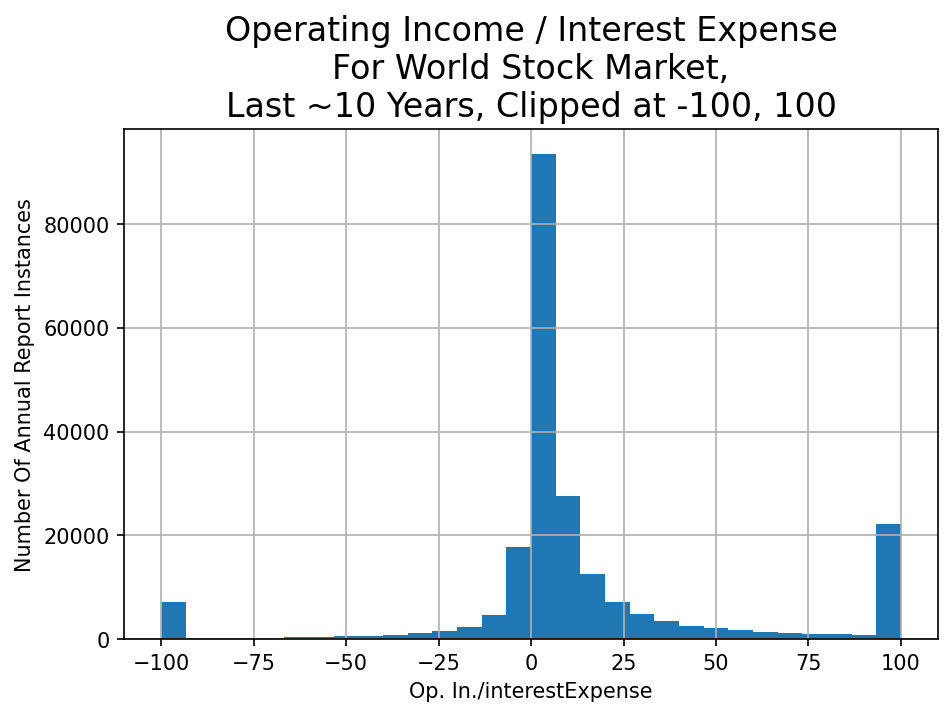

In [43]:
X['Op. In./interestExpense'] = \
(stockData['operatingIncome'] / \
 stockData['interestExpense']).clip(-1000,1000)

X['Op. In./interestExpense'].clip(-100,100).hist(bins=30)
plt.title('Operating Income / Interest Expense\nFor World Stock Market,'+\
          '\nLast ~10 Years, Clipped at -100, 100', 
          fontsize=16);
plt.xlabel('Op. In./interestExpense');
plt.ylabel('Number Of Annual Report Instances');

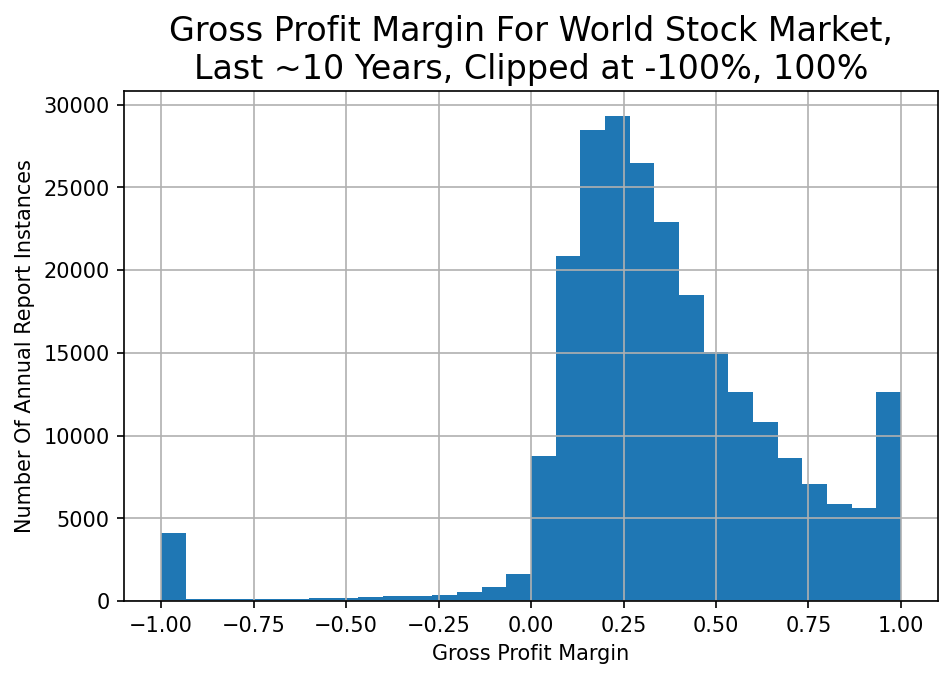

In [44]:
X['grossProfitMargin'] = \
(stockData['grossProfit']/stockData['totalRevenue']).clip(-10,10)

X['grossProfitMargin'].clip(-1,1).hist(bins=30)
plt.title('Gross Profit Margin For World Stock Market,'+\
          '\nLast ~10 Years, Clipped at -100%, 100%', 
          fontsize=16);
plt.xlabel('Gross Profit Margin');
plt.ylabel('Number Of Annual Report Instances');

### Asset Turnover

In [45]:
#X['assetTurnover'] = (stockData['propertyPlantEquipment']/stockData['totalRevenue']).clip(0,100)
X['fixedAssetTurnover'] = \
(stockData['totalRevenue'] / stockData['propertyPlantEquipment']).clip(0,300)

X['workingAssetTurnover'] = \
(stockData['totalRevenue']/(stockData['totalCurrentAssets']-\
                            stockData['totalCurrentLiabilities'])).clip(-200,200)

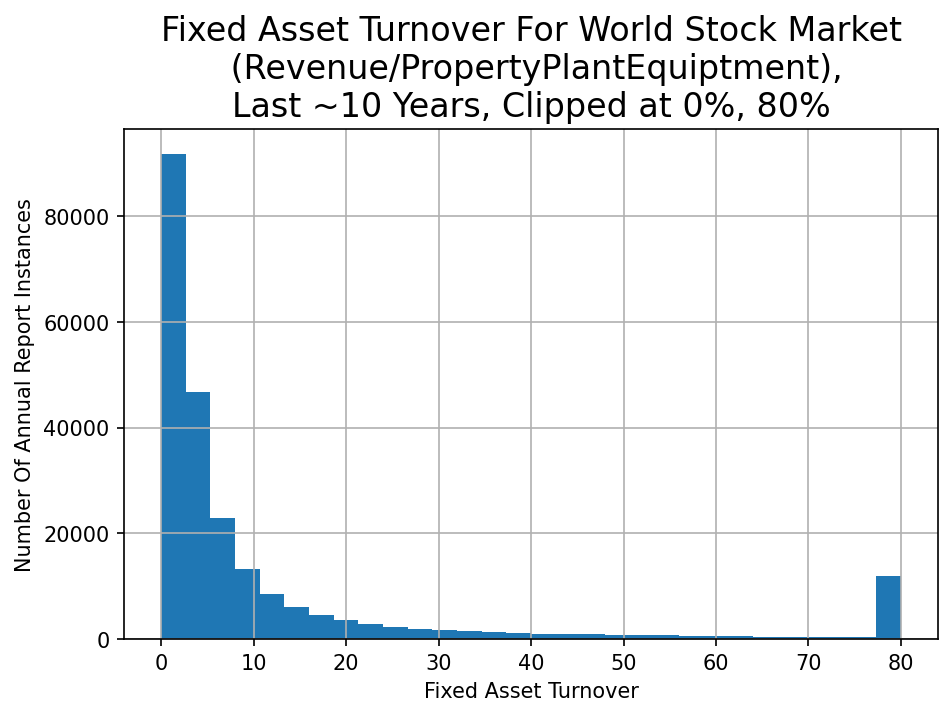

In [46]:
X['fixedAssetTurnover'].clip(-1,80).hist(bins=30)
plt.title('Fixed Asset Turnover For World Stock Market'+
          '\n (Revenue/PropertyPlantEquiptment),'+\
          '\nLast ~10 Years, Clipped at 0%, 80%', 
          fontsize=16);
plt.xlabel('Fixed Asset Turnover');
plt.ylabel('Number Of Annual Report Instances');

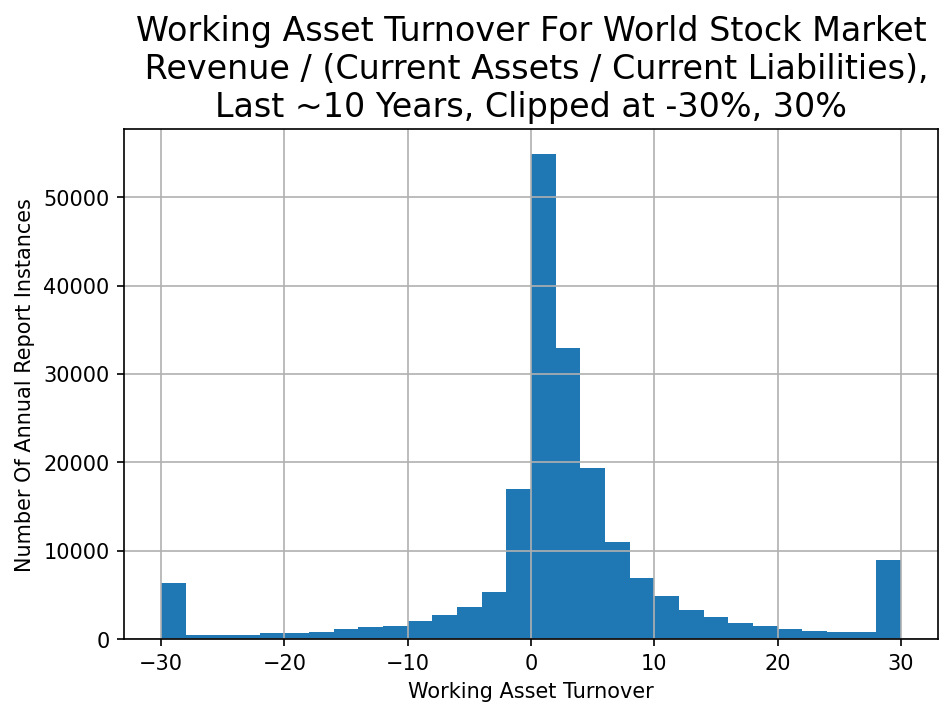

In [47]:
X['workingAssetTurnover'].clip(-30,30).hist(bins=30)
plt.title('Working Asset Turnover For World Stock Market'+
          '\n Revenue / (Current Assets / Current Liabilities),'+\
          '\nLast ~10 Years, Clipped at -30%, 30%', 
          fontsize=16);
plt.xlabel('Working Asset Turnover');
plt.ylabel('Number Of Annual Report Instances');

### Cash Ratio, Debt to Equity, Debt Ratio and Working Capital Ratio

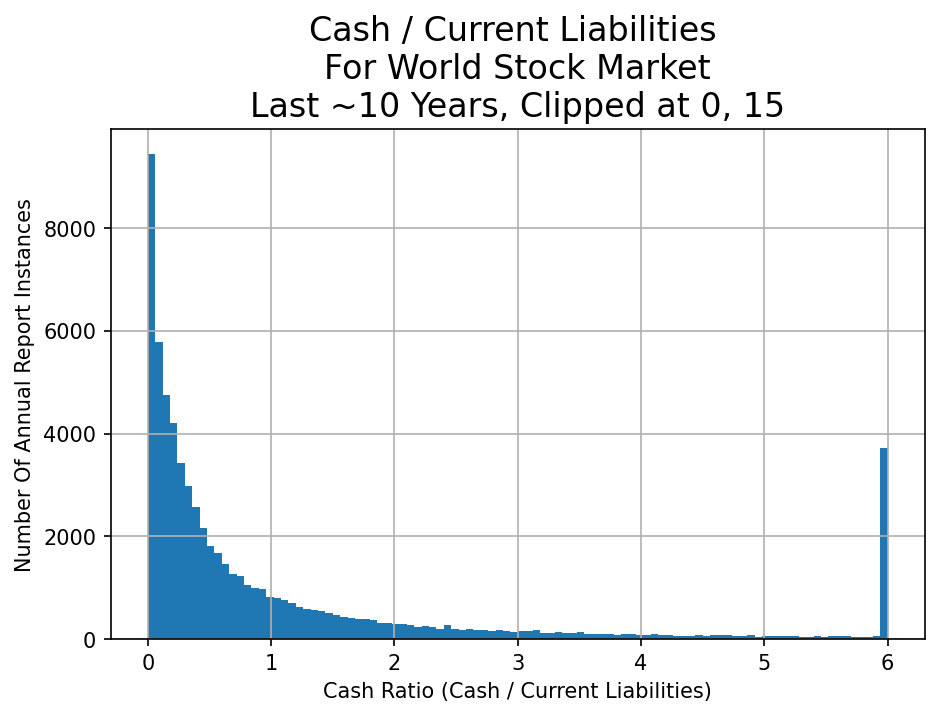

In [48]:
X['cashRatio'] = \
(stockData['cashAndShortTermInvestments'] / \
 stockData['totalCurrentLiabilities']).clip(0,50)

X['cashRatio'].clip(0,6).hist(bins=100)
plt.title('Cash / Current Liabilities \nFor World Stock Market'+
          '\nLast ~10 Years, Clipped at 0, 15', 
          fontsize=16);
plt.xlabel('Cash Ratio (Cash / Current Liabilities)');
plt.ylabel('Number Of Annual Report Instances');

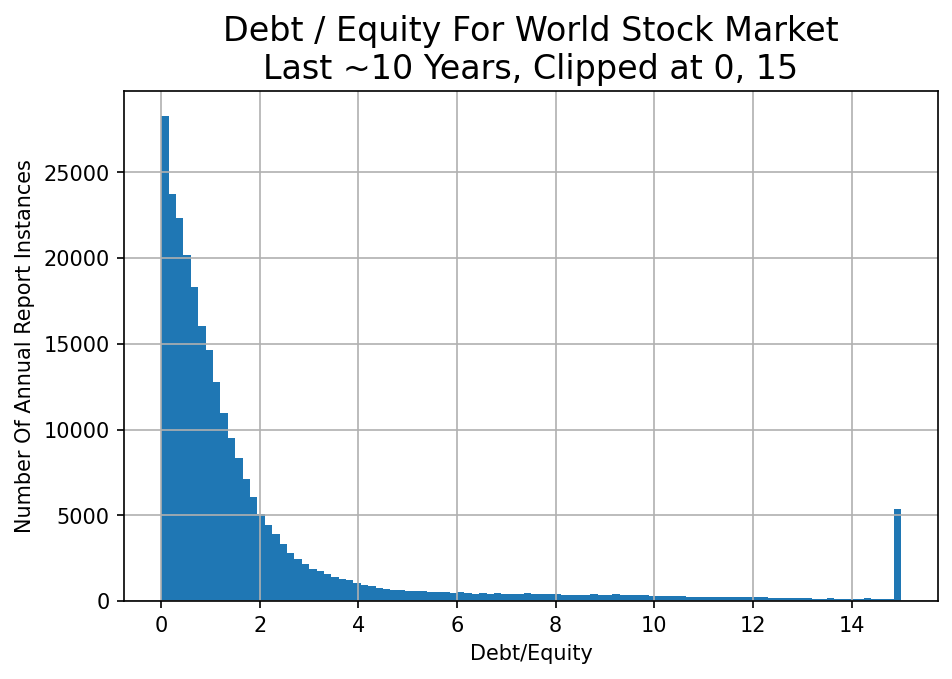

In [49]:
X['Debt/Equity'] = \
(stockData['totalLiab'] / stockData['totalStockholderEquity']).clip(-20,100)

X['Debt/Equity'].clip(0,15).hist(bins=100)
plt.title('Debt / Equity For World Stock Market'+
          '\nLast ~10 Years, Clipped at 0, 15', 
          fontsize=16);
plt.xlabel('Debt/Equity');
plt.ylabel('Number Of Annual Report Instances');

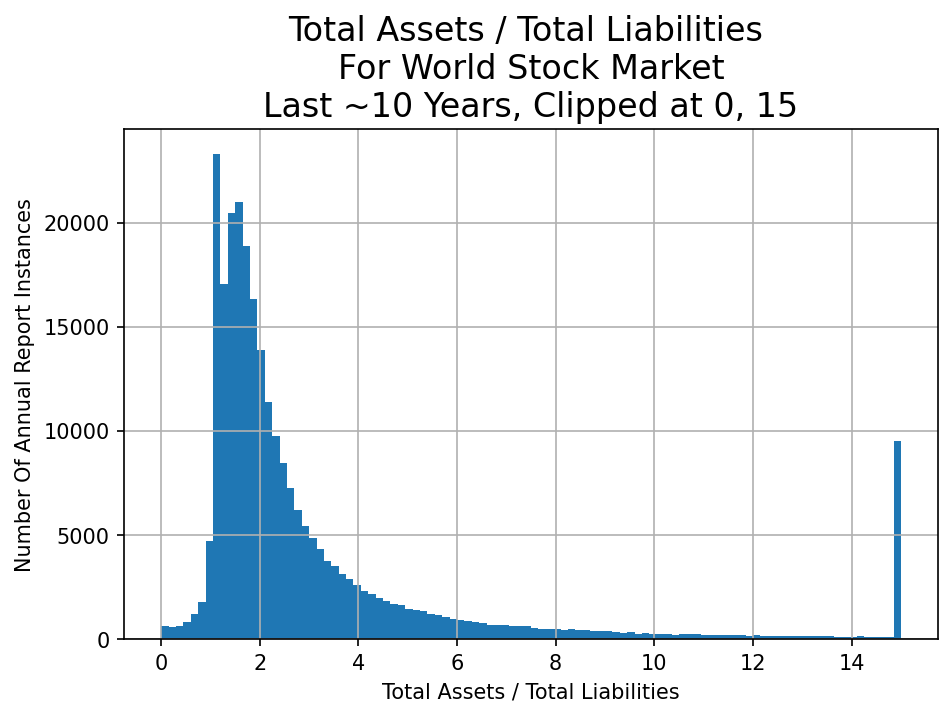

In [50]:
X['debtRatio'] = \
(stockData['totalAssets'] / stockData['totalLiab']).clip(-100,100)

X['debtRatio'].clip(0,15).hist(bins=100)
plt.title('Total Assets / Total Liabilities \nFor World Stock Market'+
          '\nLast ~10 Years, Clipped at 0, 15', 
          fontsize=16);
plt.xlabel('Total Assets / Total Liabilities');
plt.ylabel('Number Of Annual Report Instances');

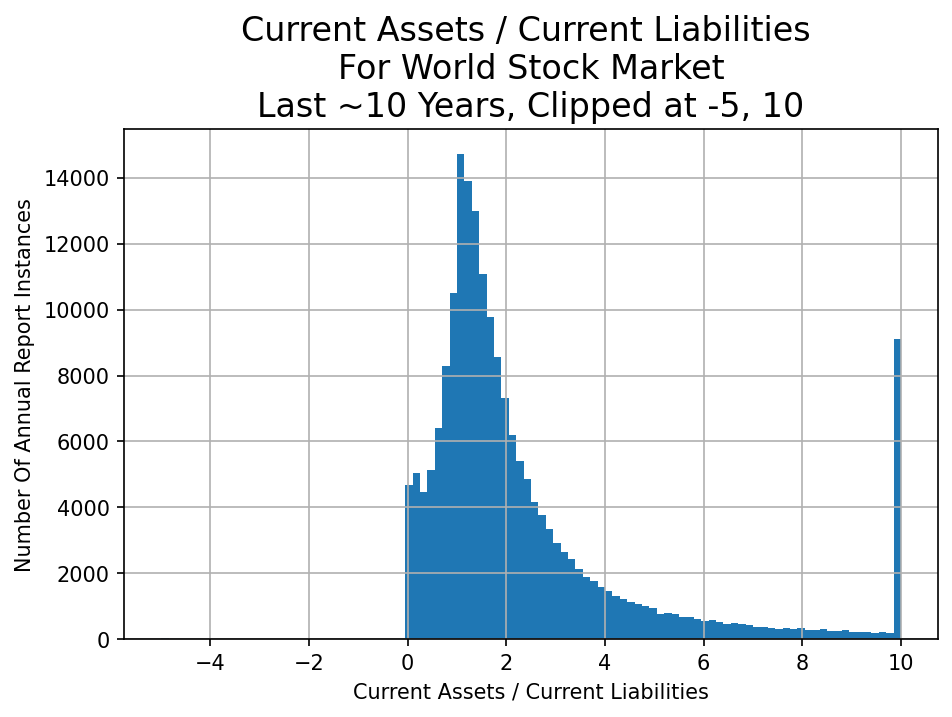

In [51]:
X['workingCapitalRatio'] = \
(stockData['totalCurrentAssets'] / \
 stockData['totalCurrentLiabilities']).clip(-5,100)

X['workingCapitalRatio'].clip(-5,10).hist(bins=100)
plt.title('Current Assets / Current Liabilities \nFor World Stock Market'+
          '\nLast ~10 Years, Clipped at -5, 10', 
          fontsize=16);

plt.xlabel('Current Assets / Current Liabilities');
plt.ylabel('Number Of Annual Report Instances');

### Other Ratios (Joel Greenblatts ratios)

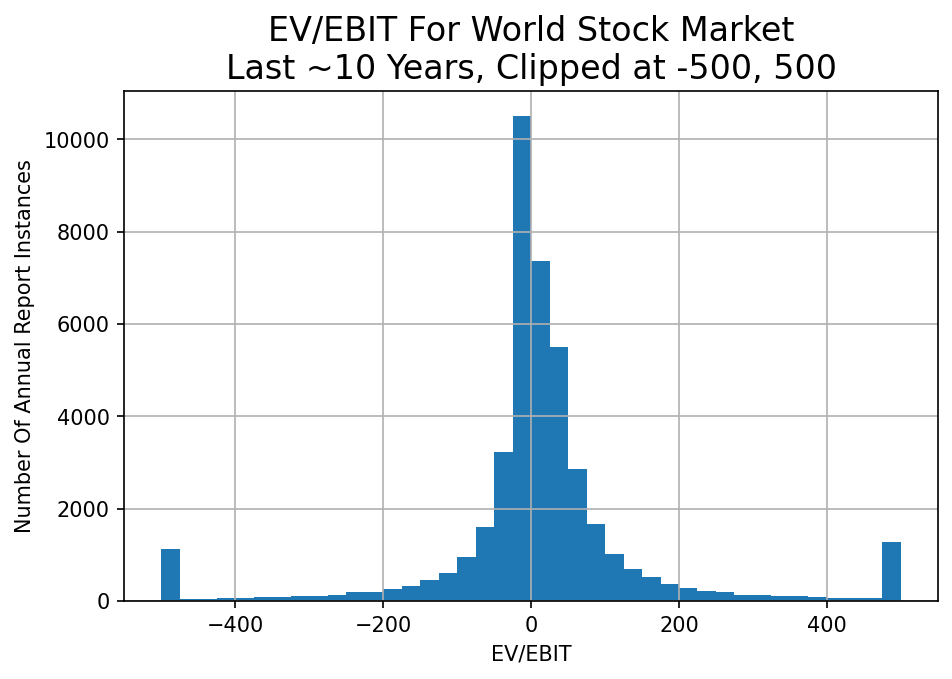

In [52]:
X['EV/EBIT'] = \
(stockData['enterpriseValue'] / stockData["EBIT"]).clip(-50000,50000)

X['EV/EBIT'].clip(-500,500).hist(bins=40)
plt.title('EV/EBIT For World Stock Market'+
          '\nLast ~10 Years, Clipped at -500, 500', 
          fontsize=16);

plt.xlabel('EV/EBIT');
plt.ylabel('Number Of Annual Report Instances');

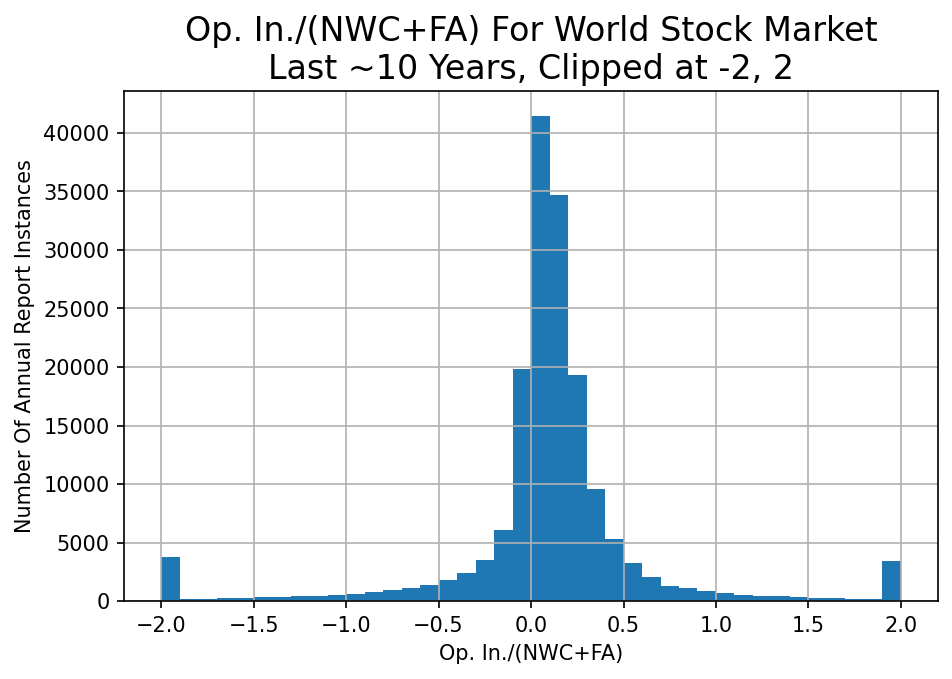

In [53]:
X['Op. In./(NWC+FA)'] = \
(stockData['operatingIncome'] / \
 (stockData['totalCurrentAssets'] - stockData['totalCurrentLiabilities'] \
  +stockData['propertyPlantEquipment'])).clip(-20,20)

X['Op. In./(NWC+FA)'].clip(-2,2).hist(bins=40)
plt.title('Op. In./(NWC+FA) For World Stock Market'+
          '\nLast ~10 Years, Clipped at -2, 2', 
          fontsize=16);

plt.xlabel('Op. In./(NWC+FA)');
plt.ylabel('Number Of Annual Report Instances');

In [54]:
### Altman ratios ###
X['EBIT/TA'] = \
(stockData['EBIT']/stockData['totalAssets']).clip(-2,2)

X['RE/TA'] = \
(stockData['retainedEarnings']/stockData['totalAssets']).clip(-20,5)

X['(CA-CL)/TA'] = ((stockData['totalCurrentAssets'] \
                   - stockData['totalCurrentLiabilities']) \
                    / stockData['totalAssets']).clip(-4,4)

## What Types of company exist?
We want to remove some that aren't going to generalise well with our data.

In [55]:
stockData['Industry'].unique()

array(['Drug Manufacturers-Specialty & Generic', 'Recreational Vehicles',
       'Textile Manufacturing', 'Insurance-Property & Casualty',
       'Conglomerates', 'Beverages-Wineries & Distilleries',
       'Integrated Freight & Logistics', 'Beverages-Brewers',
       'Lumber & Wood Production', 'Utilities-Regulated Electric',
       'Engineering & Construction', 'Auto Parts', nan,
       'Auto Manufacturers', 'Utilities-Regulated Gas',
       'Communication Equipment', 'Specialty Chemicals',
       'Real Estate Services', 'Building Materials',
       'Farm & Heavy Construction Machinery', 'Banks-Diversified',
       'Tools & Accessories', 'Utilities-Independent Power Producers',
       'Railroads', 'Semiconductors', 'Specialty Retail',
       'Marine Shipping', 'Chemicals', 'Telecom Services',
       'Specialty Industrial Machinery', 'Real Estate-Development',
       'Steel', 'Real Estate-Diversified', 'Paper & Paper Products',
       'Banks-Regional', 'Industrial Distribution', 'Pack

# All Steps Combined into One Function

In [56]:
def getXandyFundamentalStocksAnnual(stockData, priceData, verbose=False):
    '''
    Returns the X feature data and y target data for Machine Learning 
    from the stockData and priceData DataFrames.
    
    Does not edit stockData or priceData input.
    
    X data will have index corresponding to stockData input list.
    
    The y vector is in the output matrix DataFrame as one of the columns.
    '''
    if verbose:
        print('priceData shape before filter',priceData.shape)
        print('stockData shape before filter',stockData.shape)
        
    # Cleaning up the data and removing some stock data by preference.
    priceData = priceData[priceData['startAdjusted_close']>0] # buggy data
    priceData = priceData[priceData['endAdjusted_close']>0]   # buggy data
    priceData = priceData.dropna()
    stockData = stockData.loc[priceData.index] # Figures we have prices for
    stockData['Market Cap'] = \
    (stockData['SharesOutstanding'] * priceData['startClose']).clip(0,2e13)
    
    stockData=stockData[stockData['Market Cap']>0] # Imperfect data
    #stockData=stockData[stockData['netIncome']>0] # Want only companies that earn something
    stockData=stockData[stockData['totalRevenue']>0] # Only companies with revenue
    stockData=stockData[stockData['Exchange']!='PINK'] # don't want pink sheets
    stockData=stockData[stockData['CountryName']!='Germany'] # many dual listings
    
    # Mining companies, some of which are speculative
    stockData=stockData[stockData['Industry']!='Other Industrial Metals & Mining'] 
    
    # Oil and gas companies, some of which are speculative
    stockData=stockData[stockData['Industry']!='Oil & Gas E&P'] 
    stockData=stockData[stockData['HomeCategory']!='ADR'] # Don't want ADRs
    stockData=stockData[stockData['Industry']!='REIT-Mortgage'] # Don't want REIT
    
    # Don't want financials, different ball game there
    stockData=stockData[stockData['Industry']!='Money Center Banks']
    stockData=stockData[stockData['Industry']!='Banks']
    stockData=stockData[stockData['Industry']!='Banks-Regional']
    stockData=stockData[stockData['Industry']!='Banks-Diversified']    
    
    priceData = priceData.loc[stockData.index]
    if verbose:
        print('priceData shape after filter', priceData.shape)
        print('stockData shape after filter', stockData.shape)

    # FInancial Data housekeeping
    stockData.fillna(0, inplace=True)
    stockData['interestExpense']=stockData['interestExpense'].apply(np.abs)
    stockData['cashAndShortTermInvestments'] = \
    np.where(stockData['cashAndShortTermInvestments']<stockData['cash'],
             stockData['cash'],
             stockData['cashAndShortTermInvestments'])
    
    stockData['totalCurrentLiabilities'] = \
    np.where(stockData['totalCurrentLiabilities']<stockData['otherCurrentLiab'],
             stockData['otherCurrentLiab'],
             stockData['totalCurrentLiabilities'])
    
    stockData['totalCurrentAssets'] = \
    np.where(stockData['totalCurrentAssets']<stockData['otherCurrentAssets'], 
             stockData['otherCurrentAssets'],
             stockData['totalCurrentAssets'])
    
    # Current assets issue with missing figures, replace with an estimate
    # based on the ratio to total assets.
    #pd.DataFrame(stockData['totalCurrentAssets'] / \
    #             stockData['totalAssets']).clip(0,1).mean() # 0.36
    stockData['totalCurrentAssets'] = np.where(stockData['totalCurrentAssets']==0, 
                                               stockData['totalAssets']*0.36,
                                               stockData['totalCurrentAssets'])
    
    stockData['nonCurrentAssetsTotal'] = \
    np.where(stockData['nonCurrentAssetsTotal'] == 0, 
             stockData['totalAssets'] - stockData['totalCurrentAssets'],
             stockData['nonCurrentAssetsTotal'])

    stockData['totalStockholderEquity'] = \
    stockData['totalAssets'] - stockData['totalLiab']
    
    stockData['grossProfit'] = \
    stockData['totalRevenue']-stockData['costOfRevenue']

    # StockData enhancement
    stockData["EBIT"] = stockData["netIncome"] \
        - stockData["interestExpense"] \
        - stockData["incomeTaxExpense"]

    stockData['enterpriseValue'] = stockData['Market Cap']\
        +stockData['longTermDebtTotal']\
        +stockData['shortTermDebt']\
        -stockData['cashAndShortTermInvestments']
    
    # y matrix data
    stockData['1YPerf'] = \
    (priceData['endAdjusted_close'] - priceData['startAdjusted_close']) / \
    priceData['startAdjusted_close']
    
    stockData['1YPerf'] = stockData['1YPerf'].clip(-1,10)

    # Getting X
    X = pd.DataFrame() # Our Features. X matrix.
    X['1YPerf'] = stockData['1YPerf'] # Leave in X for the moment
    
    X['P/E'] = \
    (stockData['Market Cap']/stockData['netIncome']).clip(-1000,5000)#-1000,1000
    
    X['P/S'] = \
    (stockData['Market Cap']/stockData['totalRevenue']).clip(0,5000)#0,100
    
    X['P/B'] = \
    (stockData['Market Cap']/stockData['totalStockholderEquity']).clip(-100,1000)

    X['RoE'] = \
    (stockData['netIncome']/stockData['totalStockholderEquity']).clip(-10,10)
    
    X['ROCE'] = \
    (stockData['EBIT'] / (stockData['totalAssets'] - \
                          stockData['totalCurrentLiabilities'])).clip(-2,2)
    
    X['grossProfitMargin'] = \
    (stockData['grossProfit'] / stockData['totalRevenue']).clip(-10,10)

    # Asset Turnover can be split into fixed and working asset turnover.
    # Possibly not optimal due to correlation between asset turnovers.
    #X['assetTurnover'] = \
    #(stockData['propertyPlantEquipment'] / stockData['totalRevenue']).clip(0,100)
    X['fixedAssetTurnover'] = \
    (stockData['totalRevenue'] / stockData['propertyPlantEquipment']).clip(0,300)#0,100
    X['workingAssetTurnover'] = \
    (stockData['totalRevenue'] / \
     (stockData['totalCurrentAssets'] - \
      stockData['totalCurrentLiabilities'])).clip(-200,200)#-100,100

    X['workingCapitalRatio'] = \
    (stockData['totalCurrentAssets'] / \
     stockData['totalCurrentLiabilities']).clip(-5,100)
    
    X['BookEquity/TL'] = \
    (stockData['totalStockholderEquity'] / \
     stockData['totalLiab']).clip(-10,100)#inverse of debt/equity
    
    X['Debt/Equity'] = \
    (stockData['totalLiab'] / stockData['totalStockholderEquity']).clip(-20,100)#-20,40
    
    X['cashRatio'] = \
    (stockData['cashAndShortTermInvestments'] / \
     stockData['totalCurrentLiabilities']).clip(0,50)
    
    X['debtRatio'] = \
    (stockData['totalAssets']/stockData['totalLiab']).clip(-100,100)

    X['EV/EBIT'] = \
    (stockData['enterpriseValue'] / stockData["EBIT"]).clip(-50000,50000)#-100000,100000

    ### Greenblatt ratios ###
    X['Op. In./(NWC+FA)'] = \
    (stockData['operatingIncome'] / \
     (stockData['totalCurrentAssets'] - stockData['totalCurrentLiabilities'] \
      + stockData['propertyPlantEquipment'])).clip(-20,20)
    
    X['Op. In./interestExpense'] = \
    (stockData['operatingIncome'] / \
     stockData['interestExpense']).clip(-1000,1000)#-100,600

    ### Altman ratios ###
    X['EBIT/TA'] = \
    (stockData['EBIT']/stockData['totalAssets']).clip(-2,2)
    
    X['RE/TA'] = \
    (stockData['retainedEarnings']/stockData['totalAssets']).clip(-20,5)

    X['(CA-CL)/TA'] = ((stockData['totalCurrentAssets']\
                       - stockData['totalCurrentLiabilities'])\
                        /stockData['totalAssets']).clip(-4,4)
    
    return X

In [57]:
stockData=pd.read_csv('stockData_2021.csv')
stockData['date']=pd.to_datetime(stockData['date'])
priceData = pd.read_csv('priceData_2021.csv', index_col=0)
print(priceData.shape) # Check the DataFrame sizes
print(stockData.shape)
print(priceData.index[-1])
print(stockData.index[-1])

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,10,12,14,22,23,42) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(536962, 15)
(536960, 152)
536959
536959


In [58]:
features = getXandyFundamentalStocksAnnual(stockData, priceData, verbose=True)

priceData shape before filter (536962, 15)
stockData shape before filter (536960, 152)
priceData shape after filter (245705, 15)
stockData shape after filter (245705, 153)


<AxesSubplot:>

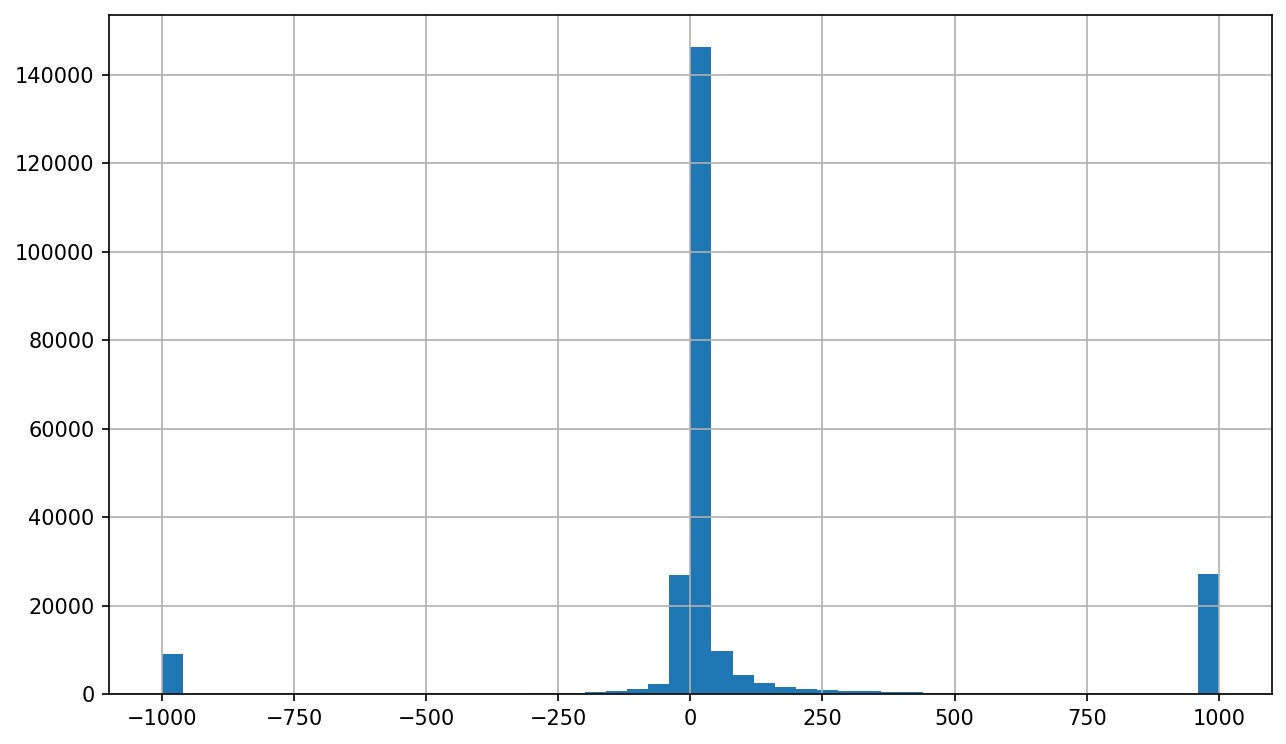

In [59]:
plt.figure(figsize=(10,6))
features['Op. In./interestExpense'].hist(bins=50)

In [60]:
stockData['CountryName'].value_counts()

USA             125293
Germany         115380
Hong Kong        32411
China            31210
India            30885
Canada           25926
Australia        23942
Korea            23143
UK               21150
Taiwan           15399
Thailand          9610
France            9479
Indonesia         8688
Malaysia          7174
Israel            4923
Turkey            4877
Sweden            4851
Singapore         4342
Italy             3840
Mexico            3820
Brazil            3436
Russia            3107
Poland            2419
Norway            2380
South Africa      2307
Finland           2162
Switzerland       1885
Denmark           1884
Spain             1655
Belgium           1548
Philippines       1367
Saudi Arabia      1355
Netherlands       1193
Greece             907
Argentina          600
Chile              556
Portugal           550
Pakistan           527
Austria            415
Ireland            190
Iceland            164
Unknown             10
Name: CountryName, dtype: int64

In [61]:
X = features.drop(columns=['1YPerf']).fillna(0) # maybe use imputer rather than 0.
y = features['1YPerf'].fillna(0)

In [62]:
X

,P/E,P/S,P/B,RoE,ROCE,grossProfitMargin,fixedAssetTurnover,workingAssetTurnover,workingCapitalRatio,BookEquity/TL,Debt/Equity,cashRatio,debtRatio,EV/EBIT,Op. In./(NWC+FA),Op. In./interestExpense,EBIT/TA,RE/TA,(CA-CL)/TA
0,26.816620,0.880630,0.907877,0.033855,0.018048,0.378024,3.168282,1.834964,3.748255,4.062929,0.246128,0.668021,5.062929,41.026795,0.042557,1000.000000,0.015087,0.554589,0.450862
1,163.704541,0.752115,0.728977,0.004453,0.003087,0.470877,1.281196,5.076150,1.591329,2.555042,0.391383,0.383850,3.555042,191.441996,0.009579,5.365682,0.002371,0.419181,0.137230
2,45.925423,1.154025,1.119339,0.024373,0.020467,0.432701,1.470584,3.380124,1.957267,2.642927,0.378368,0.650748,3.642927,42.261978,0.022187,35.353110,0.016016,0.430594,0.208185
3,7.612752,0.573782,0.586122,0.076992,0.057261,0.445133,1.245789,5.275660,1.506044,2.091147,0.478206,0.399890,3.091147,8.188278,0.094965,11.510475,0.042439,0.508946,0.130987
5,6.783145,1.231717,1.073833,0.158309,0.093938,0.417502,2.495333,1.489680,3.862203,4.225143,0.236678,0.520255,5.225143,9.977479,0.039590,1000.000000,0.078407,0.550837,0.473234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536952,11.469842,1.098071,2.252136,0.196353,0.062050,0.304257,9.480703,21.606389,1.386766,1.018038,0.982281,0.402259,2.018038,25.196483,1.072602,23.414223,0.054368,-0.082118,0.047887
536954,-15.424809,1.585102,3.095580,-0.200688,-0.390276,0.277990,15.737572,-126.437084,0.942130,1.135171,0.880924,0.266877,2.135171,-5.650383,2.303637,0.520893,-0.334895,-0.266438,-0.008212
536956,21.976809,2.207757,4.865642,0.221399,0.082300,0.297539,11.142327,115.864828,1.069851,1.237284,0.808222,0.325098,2.237284,40.988587,1.690586,27.595090,0.069906,-0.172348,0.010519
536957,9.074972,0.706510,1.647403,0.181533,0.019232,0.313446,2.124815,68.313387,1.082841,0.499573,2.001709,0.349857,1.499573,59.506701,0.335762,6.239987,0.016592,-0.049450,0.011371


In [63]:
y

0         0.167824
1         0.408167
2        -0.008705
3         0.388742
5        -0.141445
            ...   
536952   -0.235319
536954    0.836996
536956   -0.457318
536957    1.614102
536959    0.017218
Name: 1YPerf, Length: 245705, dtype: float64

# Save X and y

In [64]:
X.to_csv('filteredAnnualStockFeatures_2021.csv')
y.to_csv('filteredAnnualStockPerformance_2021.csv')

#Save Filtered priceData and StockData
stockData.to_csv('stockData_2021_filtered.csv')
priceData.to_csv('priceData_2021_filtered.csv')

# X Data for Final Stock Seleciton (no y data)

In [65]:
def getXandyFundamentalStocksDataForFinalPicks(stockData, priceData, verbose=False):
    '''
    Returns the X feature data and y target data for Machine Learning 
    from the stockData and priceData DataFrames.

    Does not edit stockData or priceData input.

    X data will have index corresponding to stockData input list.

    The y vector is in the output matrix DataFrame as one of the columns.

    This function is for present day stock seleciton X data. It outputs some missing 
    y data as we don't have future prices to create the change in price for the future
    to create that y data (this is Machine Learning prediction for the future.)
    '''
    verbose=True
    if verbose:
        print('priceData shape before filter', priceData.shape)
        print('stockData shape before filter', stockData.shape)

    # Cleaning up the data and removing some stock data by preference.
    priceData = priceData[priceData['startAdjusted_close']>0] # buggy data

    # Drop NA for beginning price data (keep NAs for end price data)
    # Because those rows will be for the present time period (we don't have future prices)
    priceData = priceData[~priceData[['startDate',
                                      'startOpen',
                                      'startHigh',
                                      'startLow',
                                      'startClose',
                                      'startAdjusted_close']].isna().any(axis=1)]

    stockData = stockData.loc[priceData.index] # Figures we have prices for
    stockData['Market Cap'] = \
    (stockData['SharesOutstanding'] * priceData['startClose']).clip(0,2e13)

    stockData=stockData[stockData['Market Cap']>0] # Imperfect data
    #stockData=stockData[stockData['netIncome']>0] # Want only companies that earn something
    stockData=stockData[stockData['totalRevenue']>0] # Only companies with revenue
    stockData=stockData[stockData['Exchange']!='PINK'] # don't want pink sheets
    stockData=stockData[stockData['CountryName']!='Germany'] # many dual listings

    # Mining companies, some of which are speculative
    stockData=stockData[stockData['Industry']!='Other Industrial Metals & Mining'] 

    # Oil and gas companies, some of which are speculative
    stockData=stockData[stockData['Industry']!='Oil & Gas E&P'] 
    stockData=stockData[stockData['HomeCategory']!='ADR'] # Don't want ADRs
    stockData=stockData[stockData['Industry']!='REIT-Mortgage'] # Don't want REIT

    # Don't want financials, different ball game there
    stockData=stockData[stockData['Industry']!='Money Center Banks']
    stockData=stockData[stockData['Industry']!='Banks']
    stockData=stockData[stockData['Industry']!='Banks-Regional']
    stockData=stockData[stockData['Industry']!='Banks-Diversified']    

    priceData = priceData.loc[stockData.index]
    if verbose:
        print('priceData shape after filter', priceData.shape)
        print('stockData shape after filter', stockData.shape)

    # FInancial Data housekeeping
    stockData.fillna(0, inplace=True)
    stockData['interestExpense']=stockData['interestExpense'].apply(np.abs)
    stockData['cashAndShortTermInvestments'] = \
    np.where(stockData['cashAndShortTermInvestments']<stockData['cash'],
             stockData['cash'],
             stockData['cashAndShortTermInvestments'])

    stockData['totalCurrentLiabilities'] = \
    np.where(stockData['totalCurrentLiabilities']<stockData['otherCurrentLiab'],
             stockData['otherCurrentLiab'],
             stockData['totalCurrentLiabilities'])

    stockData['totalCurrentAssets'] = \
    np.where(stockData['totalCurrentAssets']<stockData['otherCurrentAssets'], 
             stockData['otherCurrentAssets'],
             stockData['totalCurrentAssets'])

    # Current assets issue with missing figures, replace with an estimate
    # based on the ratio to total assets.
    #pd.DataFrame(stockData['totalCurrentAssets'] / \
    #             stockData['totalAssets']).clip(0,1).mean() # 0.36
    stockData['totalCurrentAssets'] = np.where(stockData['totalCurrentAssets']==0, 
                                               stockData['totalAssets']*0.36,
                                               stockData['totalCurrentAssets'])

    stockData['nonCurrentAssetsTotal'] = \
    np.where(stockData['nonCurrentAssetsTotal'] == 0, 
             stockData['totalAssets'] - stockData['totalCurrentAssets'],
             stockData['nonCurrentAssetsTotal'])

    stockData['totalStockholderEquity'] = \
    stockData['totalAssets'] - stockData['totalLiab']

    stockData['grossProfit'] = \
    stockData['totalRevenue']-stockData['costOfRevenue']

    # StockData enhancement
    stockData["EBIT"] = stockData["netIncome"] \
        - stockData["interestExpense"] \
        - stockData["incomeTaxExpense"]

    stockData['enterpriseValue'] = stockData['Market Cap']\
        +stockData['longTermDebtTotal']\
        +stockData['shortTermDebt']\
        -stockData['cashAndShortTermInvestments']

    # y matrix data
    stockData['1YPerf'] = \
    (priceData['endAdjusted_close'] - priceData['startAdjusted_close']) / \
    priceData['startAdjusted_close']

    stockData['1YPerf'] = stockData['1YPerf'].clip(-1,10)

    # Getting X
    X = pd.DataFrame() # Our Features. X matrix.
    X['1YPerf'] = stockData['1YPerf'] # Leave in X for the moment
    print(X.shape)

    X['P/E'] = \
    (stockData['Market Cap']/stockData['netIncome']).clip(-1000,5000)#-1000,1000

    X['P/S'] = \
    (stockData['Market Cap']/stockData['totalRevenue']).clip(0,5000)#0,100

    X['P/B'] = \
    (stockData['Market Cap']/stockData['totalStockholderEquity']).clip(-100,1000)

    X['RoE'] = \
    (stockData['netIncome']/stockData['totalStockholderEquity']).clip(-10,10)

    X['ROCE'] = \
    (stockData['EBIT'] / (stockData['totalAssets'] - \
                          stockData['totalCurrentLiabilities'])).clip(-2,2)

    X['grossProfitMargin'] = \
    (stockData['grossProfit'] / stockData['totalRevenue']).clip(-10,10)

    # Asset Turnover can be split into fixed and working asset turnover.
    # Possibly not optimal due to correlation between asset turnovers.
    #X['assetTurnover'] = \
    #(stockData['propertyPlantEquipment'] / stockData['totalRevenue']).clip(0,100)
    X['fixedAssetTurnover'] = \
    (stockData['totalRevenue'] / stockData['propertyPlantEquipment']).clip(0,300)#0,100
    X['workingAssetTurnover'] = \
    (stockData['totalRevenue'] / \
     (stockData['totalCurrentAssets'] - \
      stockData['totalCurrentLiabilities'])).clip(-200,200)#-100,100

    X['workingCapitalRatio'] = \
    (stockData['totalCurrentAssets'] / \
     stockData['totalCurrentLiabilities']).clip(-5,100)

    X['BookEquity/TL'] = \
    (stockData['totalStockholderEquity'] / \
     stockData['totalLiab']).clip(-10,100)#inverse of debt/equity

    X['Debt/Equity'] = \
    (stockData['totalLiab'] / stockData['totalStockholderEquity']).clip(-20,100)#-20,40

    X['cashRatio'] = \
    (stockData['cashAndShortTermInvestments'] / \
     stockData['totalCurrentLiabilities']).clip(0,50)

    X['debtRatio'] = \
    (stockData['totalAssets']/stockData['totalLiab']).clip(-100,100)

    X['EV/EBIT'] = \
    (stockData['enterpriseValue'] / stockData["EBIT"]).clip(-50000,50000)#-100000,100000

    ### Greenblatt ratios ###
    X['Op. In./(NWC+FA)'] = \
    (stockData['operatingIncome'] / \
     (stockData['totalCurrentAssets'] - stockData['totalCurrentLiabilities'] \
      + stockData['propertyPlantEquipment'])).clip(-20,20)

    X['Op. In./interestExpense'] = \
    (stockData['operatingIncome'] / \
     stockData['interestExpense']).clip(-1000,1000)#-100,600

    ### Altman ratios ###
    X['EBIT/TA'] = \
    (stockData['EBIT']/stockData['totalAssets']).clip(-2,2)

    X['RE/TA'] = \
    (stockData['retainedEarnings']/stockData['totalAssets']).clip(-20,5)

    X['(CA-CL)/TA'] = ((stockData['totalCurrentAssets']\
                       - stockData['totalCurrentLiabilities'])\
                        /stockData['totalAssets']).clip(-4,4)
    
    return X

In [66]:
presentStockSelectionFeatures = getXandyFundamentalStocksDataForFinalPicks(stockData, priceData, verbose=True)

priceData shape before filter (536962, 15)
stockData shape before filter (536960, 152)
priceData shape after filter (273947, 15)
stockData shape after filter (273947, 153)
(273947, 1)


In [67]:
X = presentStockSelectionFeatures.drop(columns=['1YPerf']).fillna(0) # maybe use imputer rather than 0.
y = presentStockSelectionFeatures['1YPerf'].fillna(0)

In [68]:
print(X.shape)
print(y.shape)

(273947, 19)
(273947,)


In [69]:
X.to_csv('AnnualStockFeatures_presentDayStockSelection_2021.csv')
y.to_csv('AnnualStockPerformance_presentDayStockSelection_2021.csv')